In [1]:
import pandas as pd
pd.set_option('display.max_rows', 26)

import utils.rolling_planning.procedure as rp_proced

import utils.presenter as show
import utils.checker as check

import utils.rescheduling_solver as rssv

from ProductionDaySimulation import ProductionDaySimulation

load C:\Users\konra\AppData\Local\Programs\Python\Python313\Lib\site-packages\ortools\.libs\zlib1.dll...
load C:\Users\konra\AppData\Local\Programs\Python\Python313\Lib\site-packages\ortools\.libs\abseil_dll.dll...
load C:\Users\konra\AppData\Local\Programs\Python\Python313\Lib\site-packages\ortools\.libs\utf8_validity.dll...
load C:\Users\konra\AppData\Local\Programs\Python\Python313\Lib\site-packages\ortools\.libs\re2.dll...
load C:\Users\konra\AppData\Local\Programs\Python\Python313\Lib\site-packages\ortools\.libs\libprotobuf.dll...
load C:\Users\konra\AppData\Local\Programs\Python\Python313\Lib\site-packages\ortools\.libs\highs.dll...
load C:\Users\konra\AppData\Local\Programs\Python\Python313\Lib\site-packages\ortools\.libs\ortools.dll...


In [2]:
max_time = 60*60*3 # 3 h

## Laden der Produktionsaufträge

In [3]:
file_template = "data/05_{text}.csv"

In [4]:
file = file_template.format(text= "all_jobs")
df_jobs_all = pd.read_csv(file)
df_jobs_all

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
0,Job_000,0,2015,1440,395,180
1,Job_001,86,2438,1440,510,488
2,Job_002,149,2672,1440,568,664
3,Job_003,203,2981,1440,655,886
4,Job_004,241,2250,1440,393,417
...,...,...,...,...,...,...
375,Job_375,28525,31302,28800,655,1847
376,Job_376,28531,30541,28800,393,1348
377,Job_377,28532,31055,28800,568,1687
378,Job_378,28655,30670,28800,395,1475


In [5]:
df_jobs_all.loc[df_jobs_all['Arrival'].idxmin(), 'Job']

'Job_000'

In [6]:
file = file_template.format(text= "all_ops")
df_ops_all = pd.read_csv(file)
df_ops_all

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
3795,Job_379,5,M9,76
3796,Job_379,6,M5,47
3797,Job_379,7,M3,52
3798,Job_379,8,M4,90


## Laden der Initialisierungsdaten vom Tag 1

In [7]:
day_numb = 1

In [8]:
# Waiting Plan
file = file_template.format(text= f"plan_{day_numb:02d}_waiting")
df_plan_waiting = pd.read_csv(file)
df_plan_waiting

,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_003,9,M5,203,2981,2938,43,2981,0,0,0
1,Job_008,9,M8,731,3339,3230,74,3304,-35,0,35
2,Job_009,9,M7,764,3205,3160,45,3205,0,0,0
3,Job_010,9,M3,872,3310,3231,79,3310,0,0,0
4,Job_011,8,M4,924,3531,2966,26,2992,-539,0,539
5,Job_011,9,M8,924,3531,3457,74,3531,0,0,0
6,Job_012,9,M8,981,3334,3304,30,3334,0,0,0
7,Job_013,9,M7,1160,3471,3446,25,3471,0,0,0
8,Job_014,5,M8,1165,3942,3006,52,3058,-884,0,884
9,Job_014,6,M7,1165,3942,3058,85,3143,-799,0,799


In [9]:
# bereits Ausgeführte Operationen
file = file_template.format(text= f"execution_{day_numb:02d}")
df_execution = pd.read_csv(file)
df_execution

,Job,Operation,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
0,Job_000,0,0,M0,1440.00,16.53,1456.53,1456.53
1,Job_000,1,0,M1,1486.00,97.90,1583.90,1583.90
2,Job_000,2,0,M2,1653.44,14.62,1668.06,1668.06
3,Job_000,3,0,M3,1668.06,24.14,1692.20,1692.20
4,Job_000,4,0,M4,1769.95,56.38,1826.33,1826.33
...,...,...,...,...,...,...,...,...
155,Job_017,8,1295,M8,2824.00,35.80,1564.80,2859.80
156,Job_018,0,1398,M1,2471.34,66.79,1140.13,2538.13
157,Job_018,1,1398,M0,2538.13,9.47,1149.60,2547.60
158,Job_018,2,1398,M2,2547.60,81.97,1231.57,2629.57


In [10]:
# für die Vergangenheit geplante Operationen, die nicht geschaft abgearbeitet wurden 
file = file_template.format(text= f"plan_{day_numb:02d}_undone")
df_plan_undone = pd.read_csv(file)
df_plan_undone

,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_011,7,M7,924,3531,2877,89,2966,-565,0,565
1,Job_013,7,M6,1160,3471,2778,65,2843,-628,0,628
2,Job_013,8,M4,1160,3471,2843,6,2849,-622,0,622
3,Job_014,4,M6,1165,3942,2843,9,2852,-1090,0,1090
4,Job_016,5,M5,1172,3695,2824,10,2834,-861,0,861


In [11]:
def print_earliest_job(df_jobs_waiting, info="Info"):
    """
    Gibt den frühesten wartenden Job mit Ankunftszeit und Deadline in einer Zeile formatiert aus.

    Format:
    <Info> frühste: <Jobname>    Arrival: <arrival>    Deadline: <deadline>

    Parameter:
    df_jobs_waiting (pd.DataFrame): DataFrame mit Spalten 'Job', 'Arrival' und 'Deadline'.
    info (str): Informationstext für die Ausgabe.
    """
    if df_jobs_waiting.empty:
        print(f"{info} earliest: Keine wartenden Jobs vorhanden.")
        return

    row = df_jobs_waiting.loc[df_jobs_waiting['Arrival'].idxmin()]
    jobname = row['Job']
    arrival = row['Arrival']
    deadline = row['Deadline']
    print(f"\t{info} earliest {jobname}:\tArrival: {arrival}\tDeadline: {deadline}")


## Rolling Planning ab Tag 2

In [12]:
file_template = "data/06_devpen_{text}.csv"

In [13]:
first_start = 2
last_planning_start = 12

day_length = 1440

Day 02: [2880, 4320)
	Current earliest Job_019:	Arrival: 1440	Deadline: 3455
	Undone earliest Job_011:	Arrival: 924	Deadline: 3531
	Wating earliest Job_003:	Arrival: 203	Deadline: 2981

Solver-Status         : OPTIMAL
Objective Value       : 15980.00
Best Objective Bound  : 15980.00
Laufzeit              : 0.48 Sekunden
Deviation terms       : 25


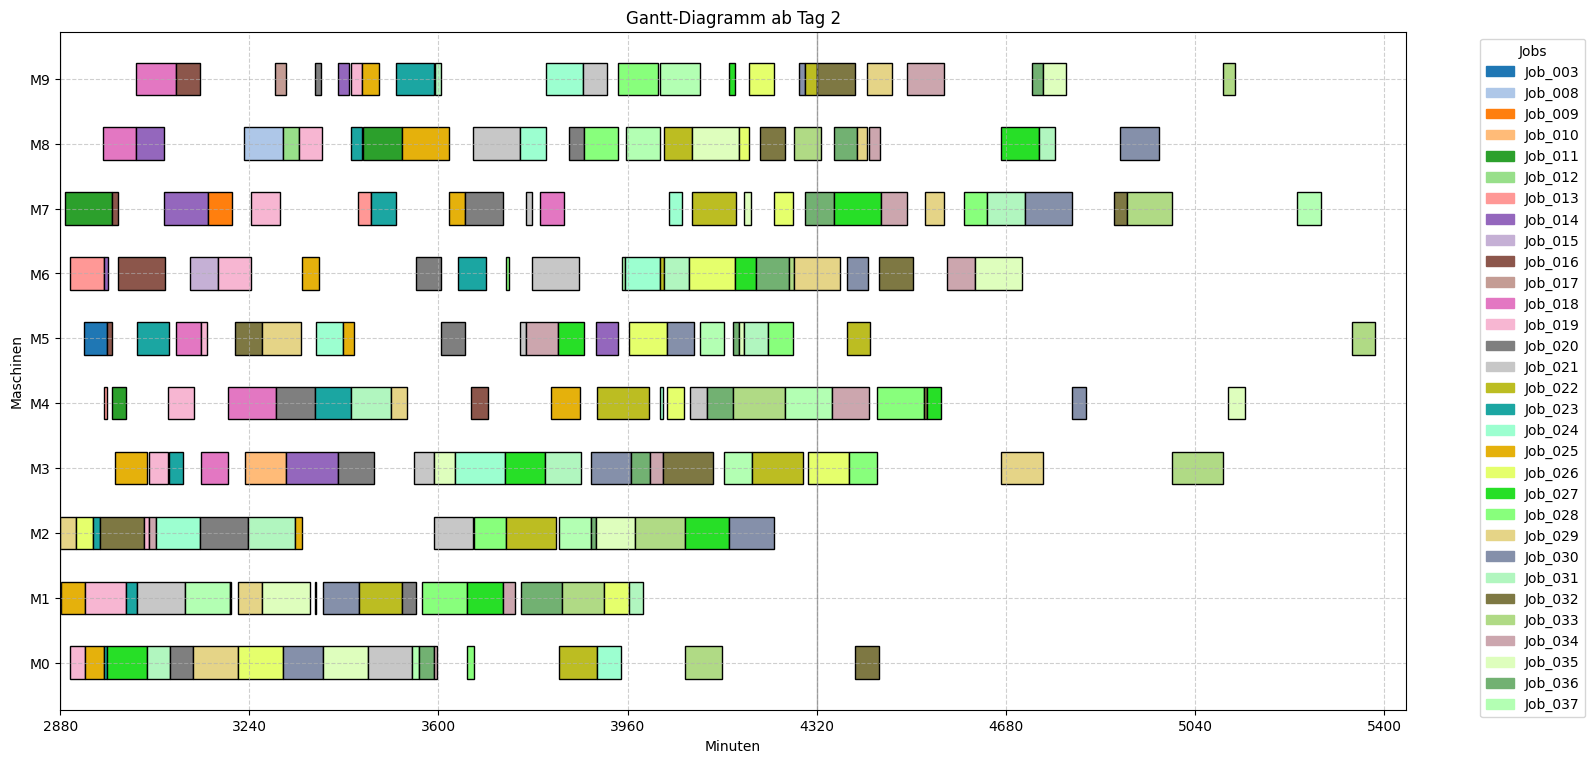

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job
label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         3
0              27
0 - 60          1
60 - 120        0
120 - 180       0
180 - 240       0
>240            0
Name: count, dtype: int64
Number of waiting operations: 37
[48:00:00] Job_029 started on M2
[48:01:00] Job_025 started on M1
[48:10:00] Job_011 started on M7
[48:18:00] Job_013 started on M6
[48:18:00] Job_019 started on M0
[48:33:55] Job_029 finished on M2 (after 33 minutes 55 seconds)
[48:33:55] Job_026 started on M2
[48:38:45] Job_025 finished on M1 (after 37 minutes 46 seconds)
[48:41:03] Job_019 finished on M0 (after 23 minutes 03 seconds)
[48:46:00] Job_003 started on M5
[48:47:00] Job_025 started on M0
[48:47:00] Job_019 started on M1
[49:06:25] Job_026 finished on M2 (afte

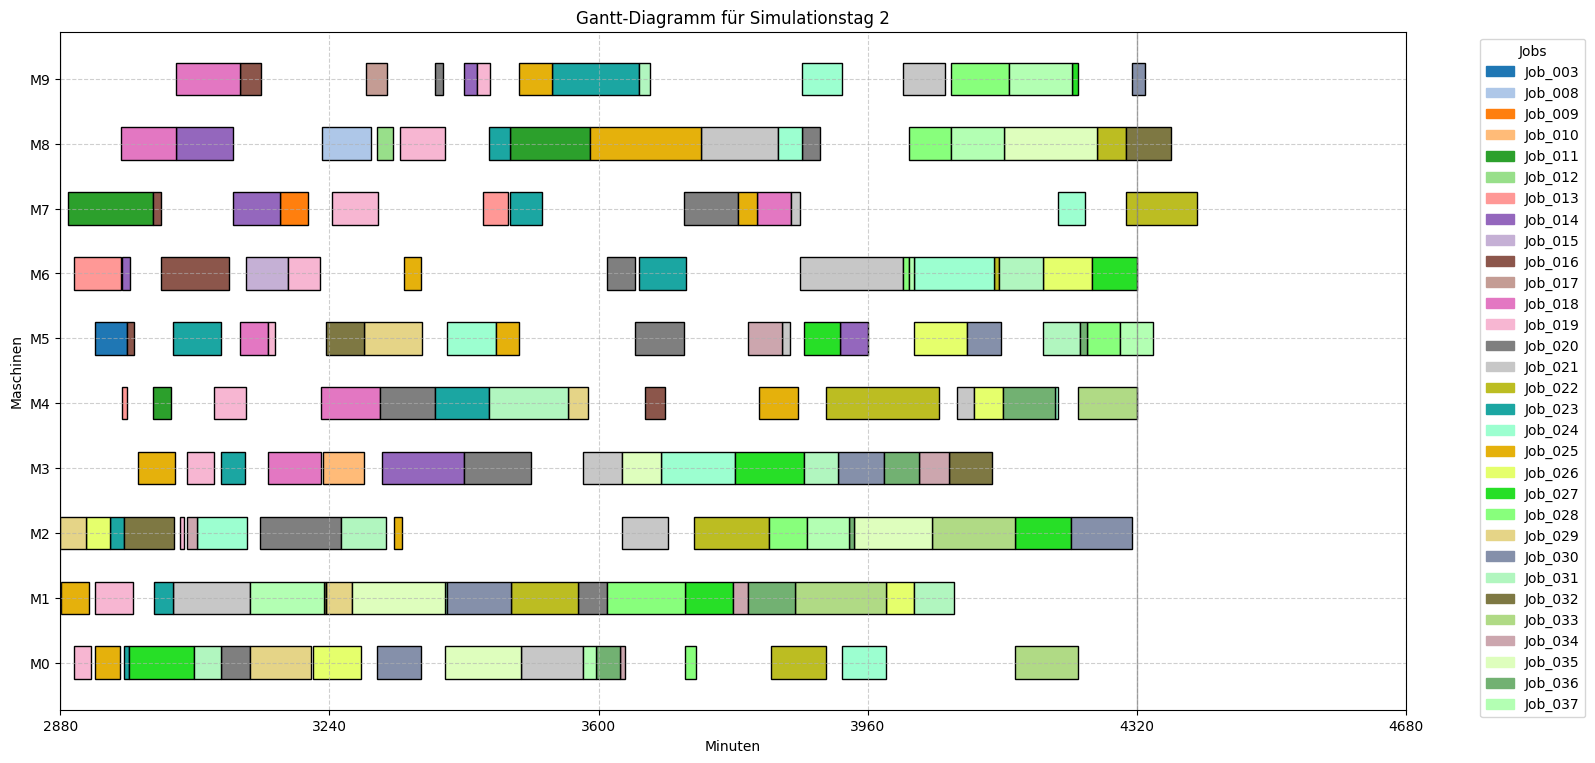

Number of undone operations: 15
_______________________________________________________________________________
Day 03: [4320, 5760)
	Current earliest Job_038:	Arrival: 2880	Deadline: 4895
	Undone earliest Job_022:	Arrival: 1643	Deadline: 4421
	Wating earliest Job_022:	Arrival: 1643	Deadline: 4421

Solver-Status         : OPTIMAL
Objective Value       : 271600.00
Best Objective Bound  : 271060.00
Laufzeit              : 8998.31 Sekunden
Deviation terms       : 37


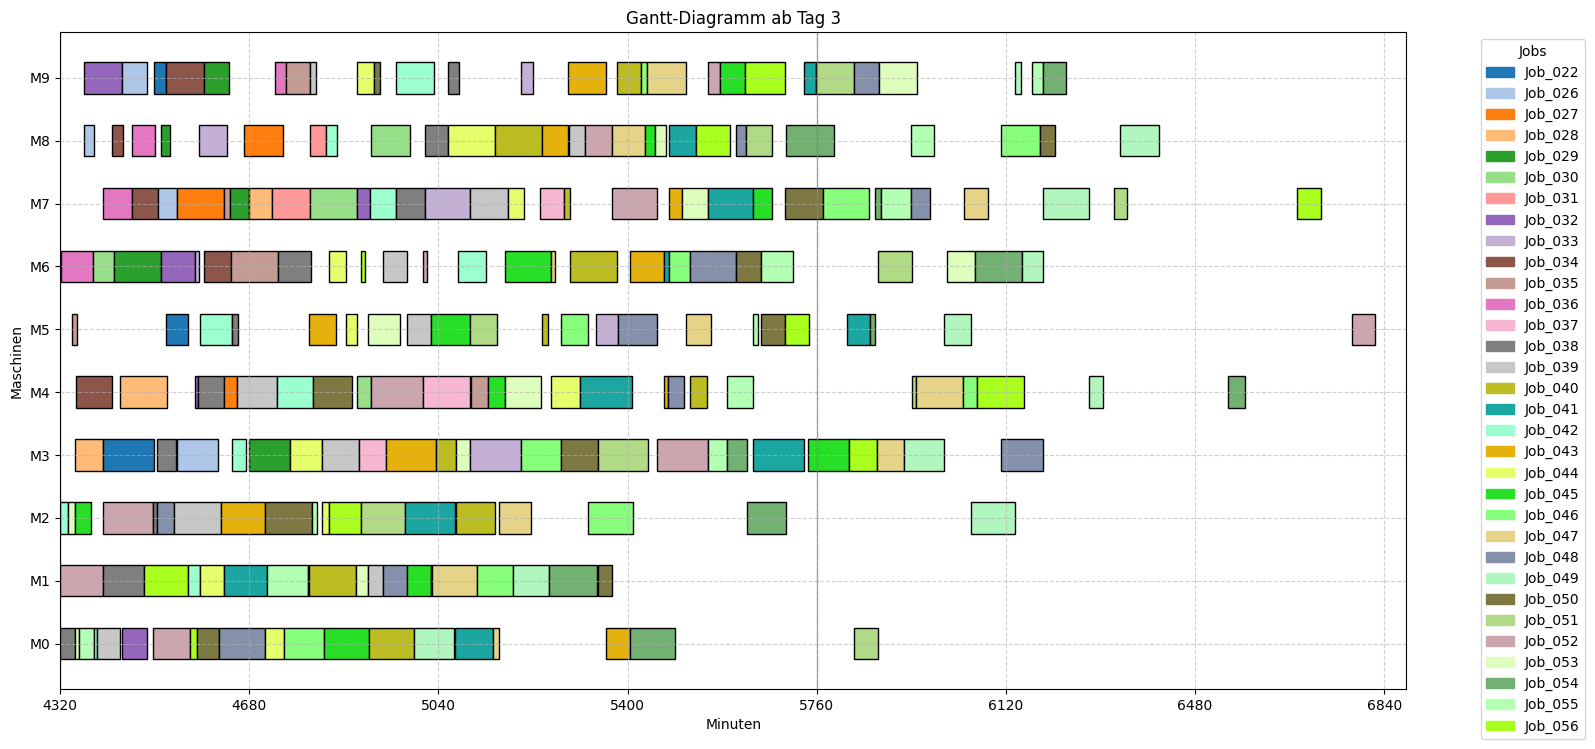

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job
label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         3
0              21
0 - 60          4
60 - 120        1
120 - 180       1
180 - 240       2
>240            0
Name: count, dtype: int64
Number of waiting operations: 37
[72:00:00] Job_038 started on M0
[72:00:00] Job_042 started on M2
[72:00:00] Job_052 started on M1
[72:01:00] Job_036 started on M6
[72:14:21] Job_042 finished on M2 (after 14 minutes 21 seconds)
[72:14:21] Job_053 started on M2
[72:21:11] Job_038 finished on M0 (after 21 minutes 11 seconds)
[72:22:00] Job_035 started on M5
[72:24:08] Job_053 finished on M2 (after 09 minutes 47 seconds)
[72:28:00] Job_045 started on M2
[72:29:00] Job_028 started on M3
[72:29:00] Job_053 started on M0
[72:30:00] Job_034 started on M4
[72:36

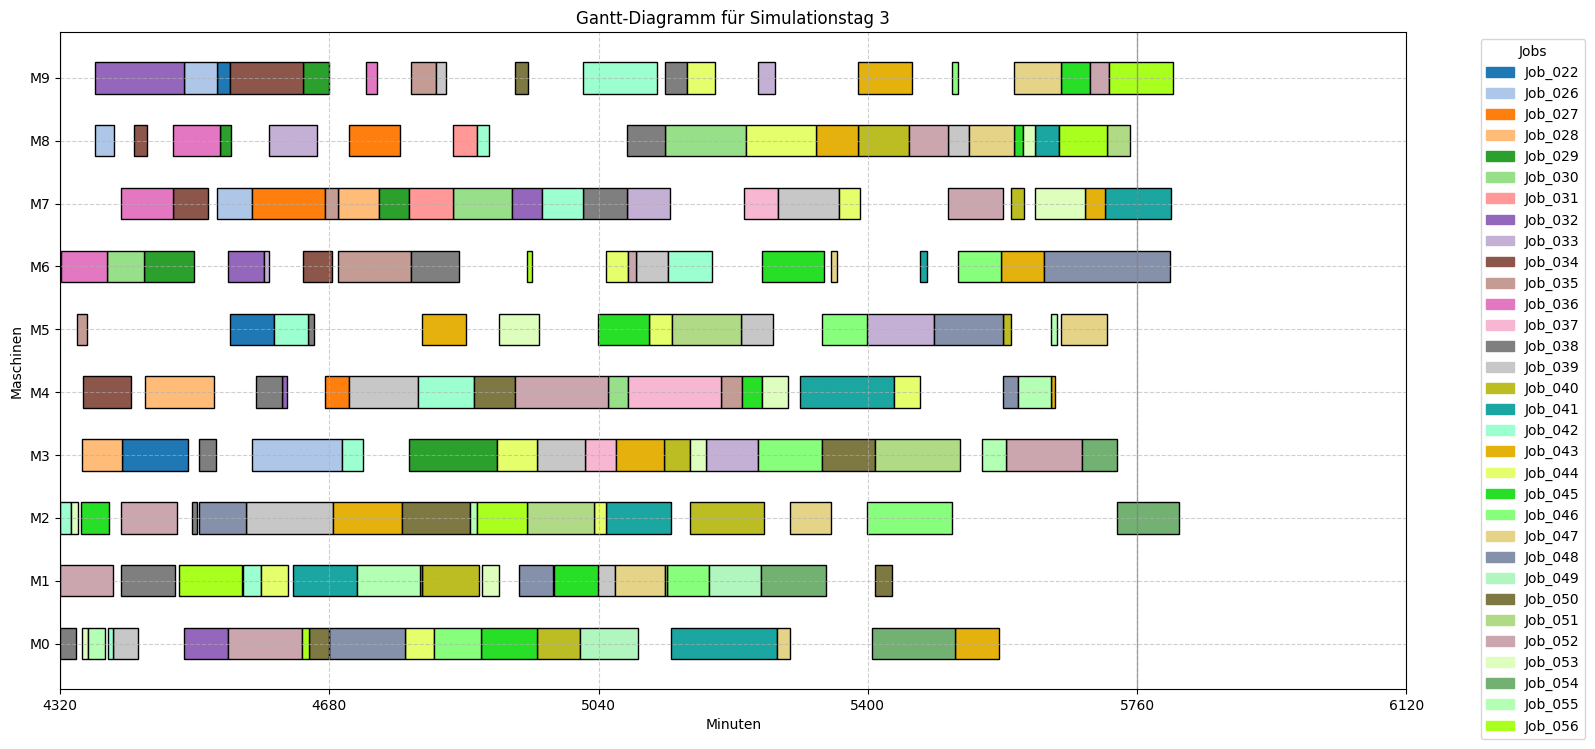

Number of undone operations: 15
_______________________________________________________________________________
Day 04: [5760, 7200)
	Current earliest Job_057:	Arrival: 4320	Deadline: 6335
	Undone earliest Job_040:	Arrival: 3029	Deadline: 5552
	Wating earliest Job_041:	Arrival: 3083	Deadline: 5861

Solver-Status         : FEASIBLE
Objective Value       : 316640.00
Best Objective Bound  : 289880.00
Laufzeit              : 10806.22 Sekunden
Deviation terms       : 37


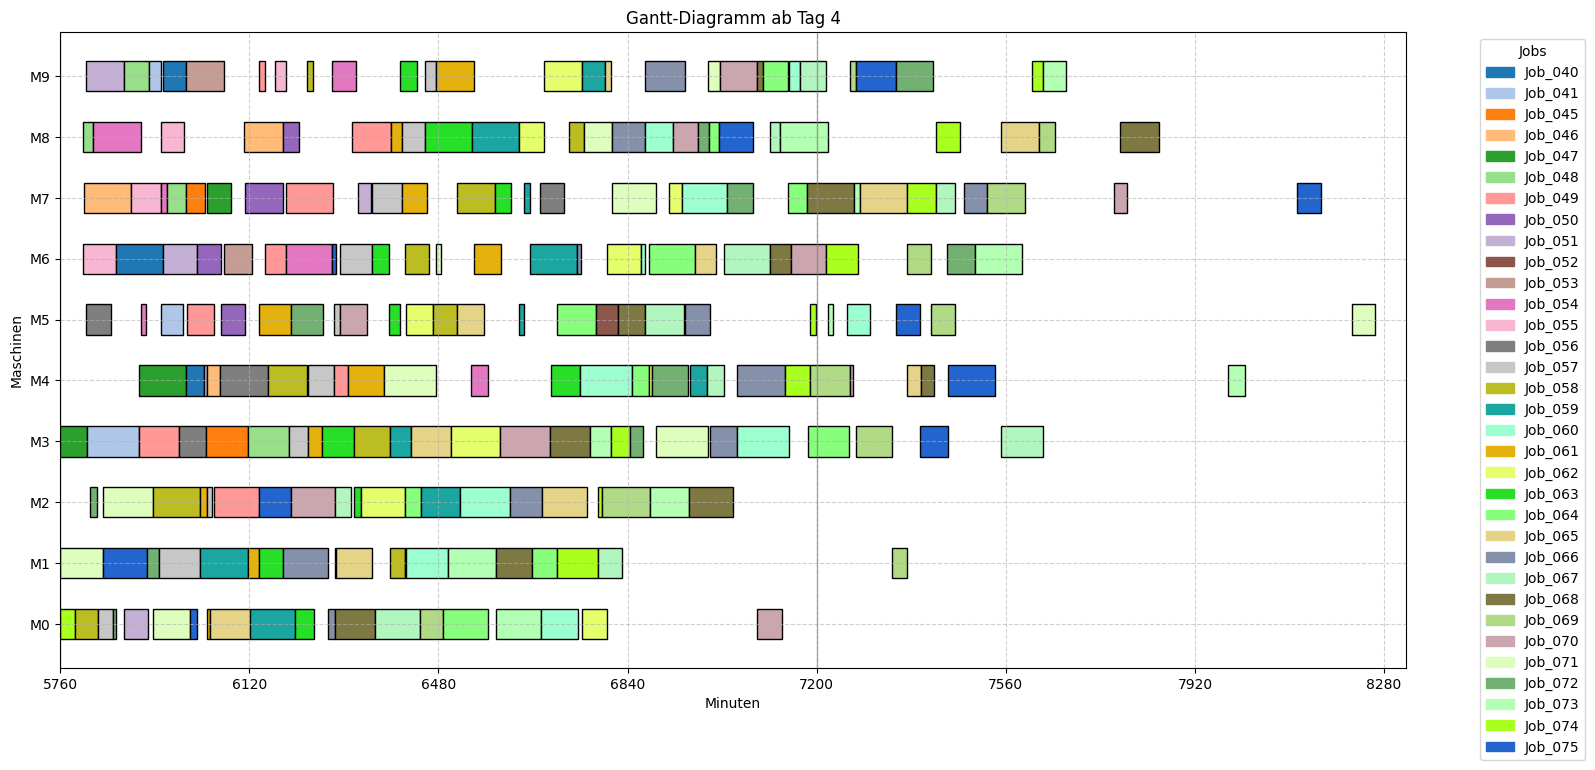

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job
label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         3
0              23
0 - 60          2
60 - 120        1
120 - 180       2
180 - 240       0
>240            2
Name: count, dtype: int64
Number of waiting operations: 35
[96:00:00] Job_047 started on M3
[96:00:00] Job_071 started on M1
[96:00:00] Job_074 started on M0
[96:18:58] Job_074 finished on M0 (after 18 minutes 58 seconds)
[96:29:00] Job_058 started on M0
[96:44:00] Job_048 started on M8
[96:44:00] Job_055 started on M6
[96:46:00] Job_046 started on M7
[96:49:00] Job_051 started on M9
[96:49:00] Job_056 started on M5
[96:51:07] Job_071 finished on M1 (after 51 minutes 08 seconds)
[96:57:00] Job_072 started on M2
[96:57:55] Job_047 finished on M3 (after 57 minutes 55 seconds)
[96:57

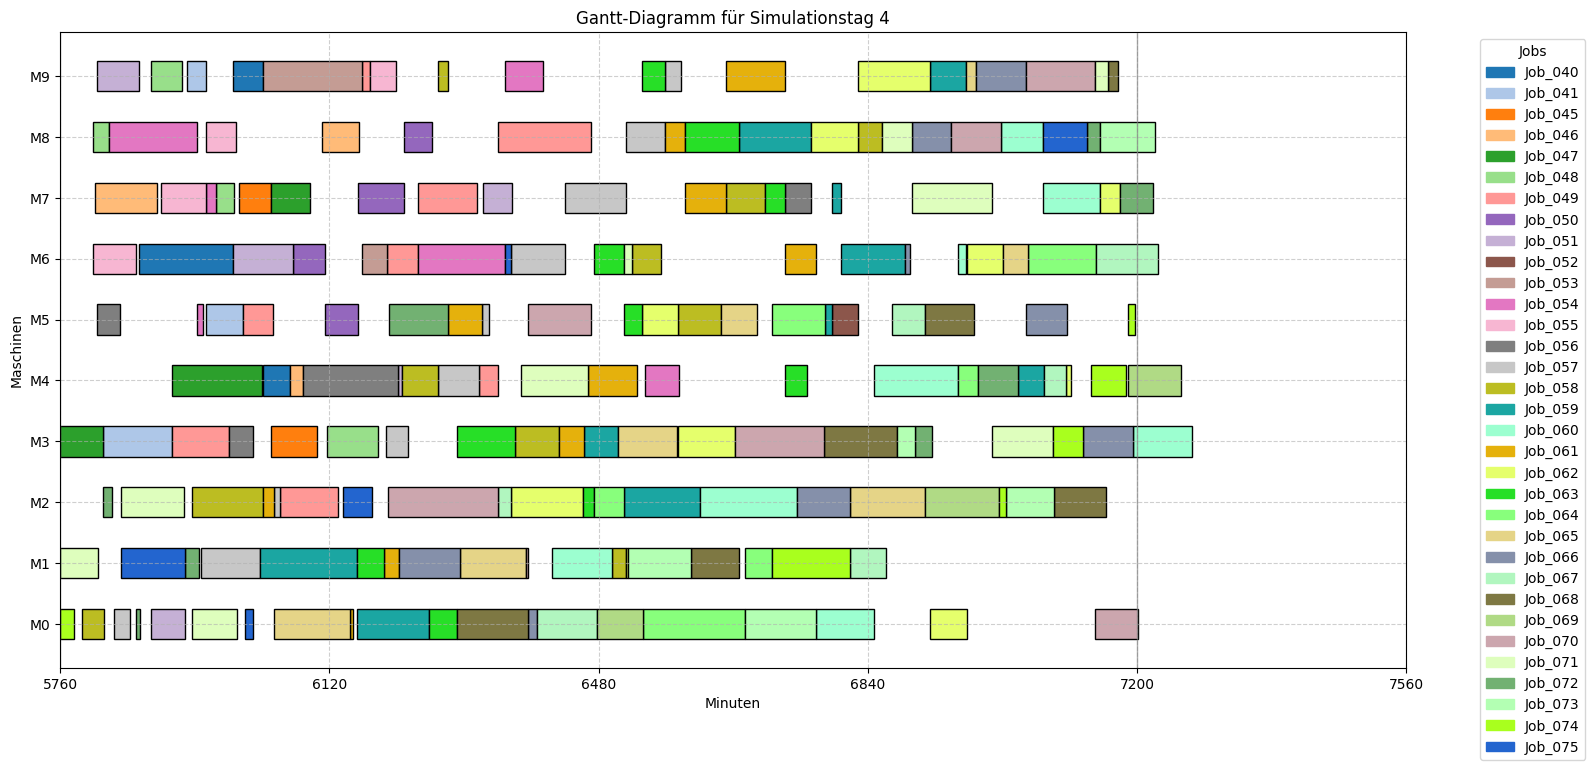

Number of undone operations: 11
_______________________________________________________________________________
Day 05: [7200, 8640)
	Current earliest Job_076:	Arrival: 5760	Deadline: 7775
	Undone earliest Job_060:	Arrival: 4523	Deadline: 7301
	Wating earliest Job_060:	Arrival: 4523	Deadline: 7301

Solver-Status         : OPTIMAL
Objective Value       : 121540.00
Best Objective Bound  : 121540.00
Laufzeit              : 397.99 Sekunden
Deviation terms       : 35


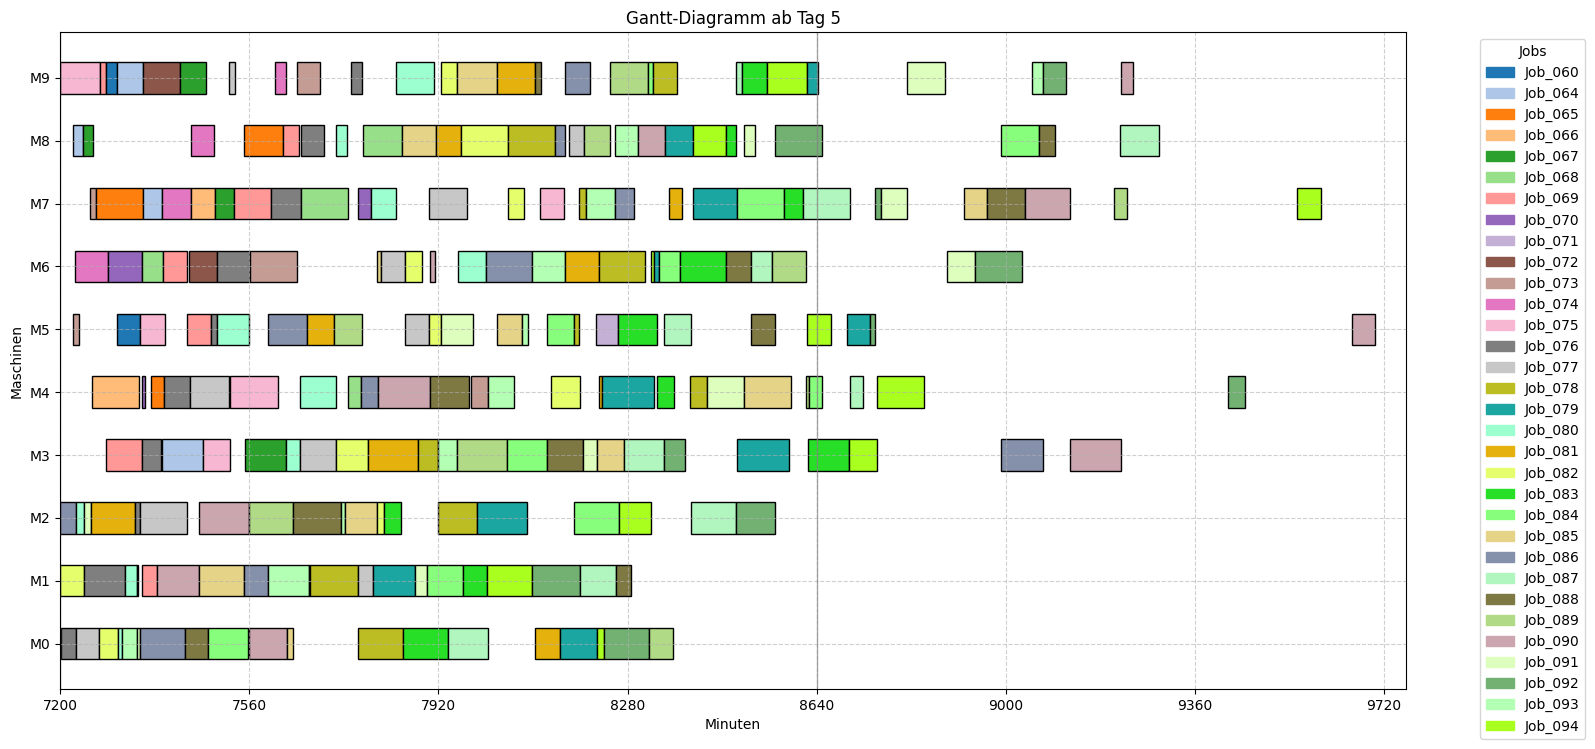

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job
label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         4
0              26
0 - 60          1
60 - 120        0
120 - 180       0
180 - 240       1
>240            0
Name: count, dtype: int64
Number of waiting operations: 25
[120:00:00] Job_075 started on M9
[120:00:00] Job_082 started on M1
[120:00:00] Job_086 started on M2
[120:02:00] Job_076 started on M0
[120:25:00] Job_064 started on M8
[120:25:00] Job_073 started on M5
[120:29:00] Job_074 started on M6
[120:30:56] Job_076 finished on M0 (after 28 minutes 57 seconds)
[120:31:00] Job_077 started on M0
[120:37:18] Job_073 finished on M5 (after 12 minutes 18 seconds)
[120:39:22] Job_086 finished on M2 (after 39 minutes 22 seconds)
[120:39:22] Job_080 started on M2
[120:39:26] Job_082 finishe

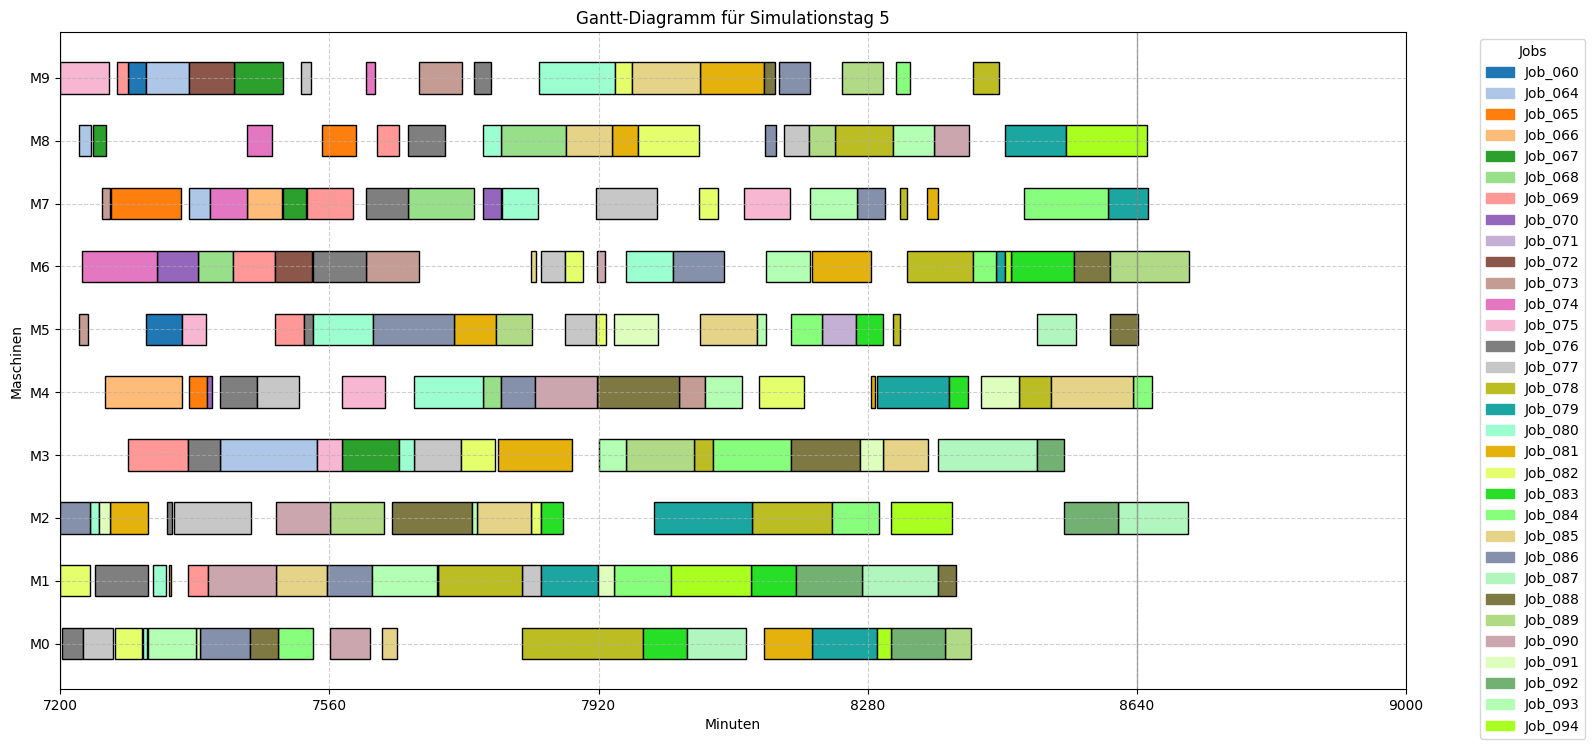

Number of undone operations: 14
_______________________________________________________________________________
Day 06: [8640, 10080)
	Current earliest Job_095:	Arrival: 7200	Deadline: 9215
	Undone earliest Job_079:	Arrival: 5963	Deadline: 8741
	Wating earliest Job_079:	Arrival: 5963	Deadline: 8741

Solver-Status         : OPTIMAL
Objective Value       : 111960.00
Best Objective Bound  : 111740.00
Laufzeit              : 11.10 Sekunden
Deviation terms       : 25


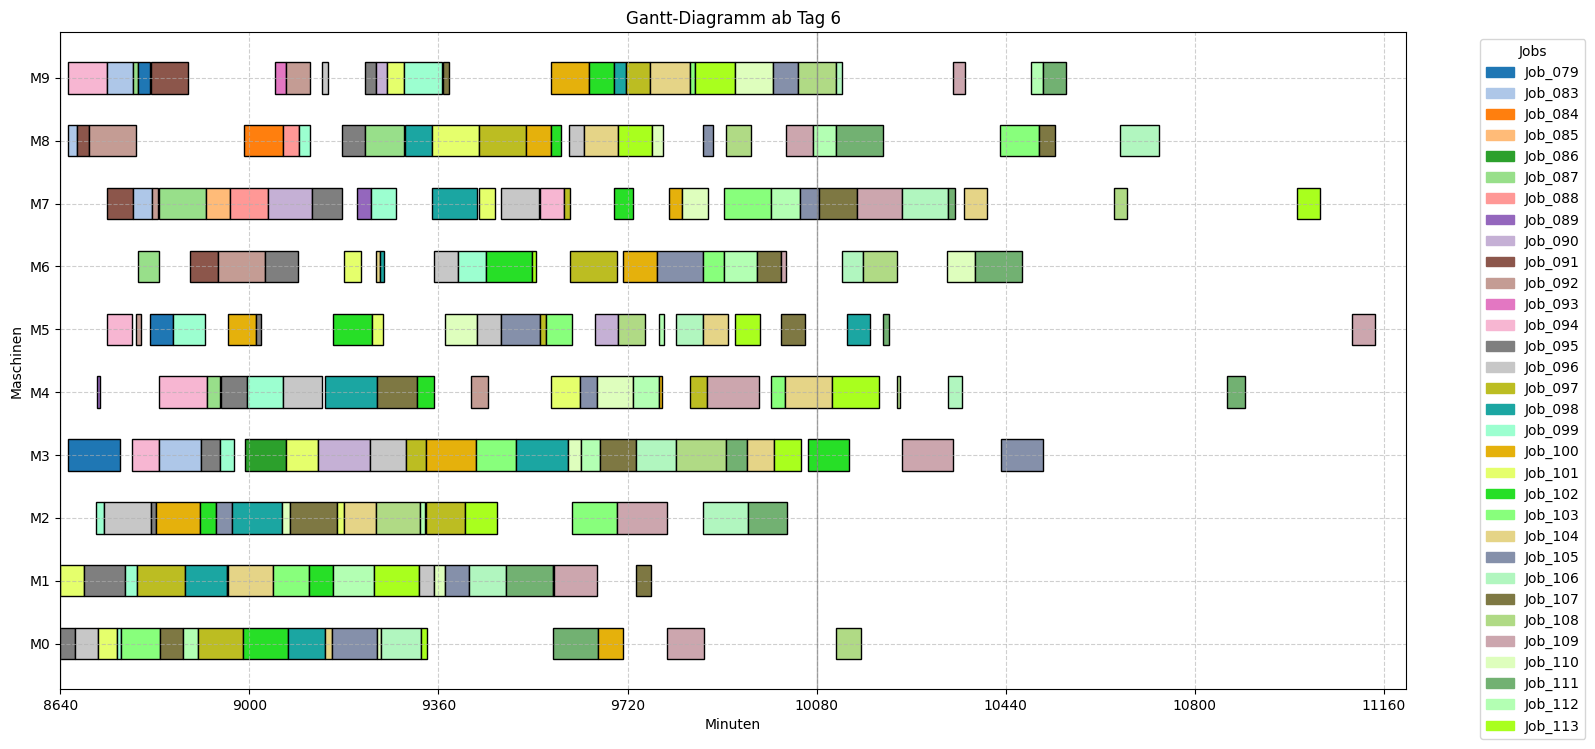

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job
label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         3
0              25
0 - 60          2
60 - 120        1
120 - 180       0
180 - 240       1
>240            0
Name: count, dtype: int64
Number of waiting operations: 29
[144:00:00] Job_095 started on M0
[144:00:00] Job_101 started on M1
[144:14:00] Job_083 started on M8
[144:14:00] Job_094 started on M9
[144:15:00] Job_079 started on M3
[144:27:42] Job_083 finished on M8 (after 13 minutes 42 seconds)
[144:29:02] Job_095 finished on M0 (after 29 minutes 02 seconds)
[144:29:02] Job_096 started on M0
[144:33:00] Job_091 started on M8
[144:33:48] Job_101 finished on M1 (after 33 minutes 49 seconds)
[144:46:00] Job_095 started on M1
[144:50:00] Job_091 finished on M8 (after 17 minutes 01 secon

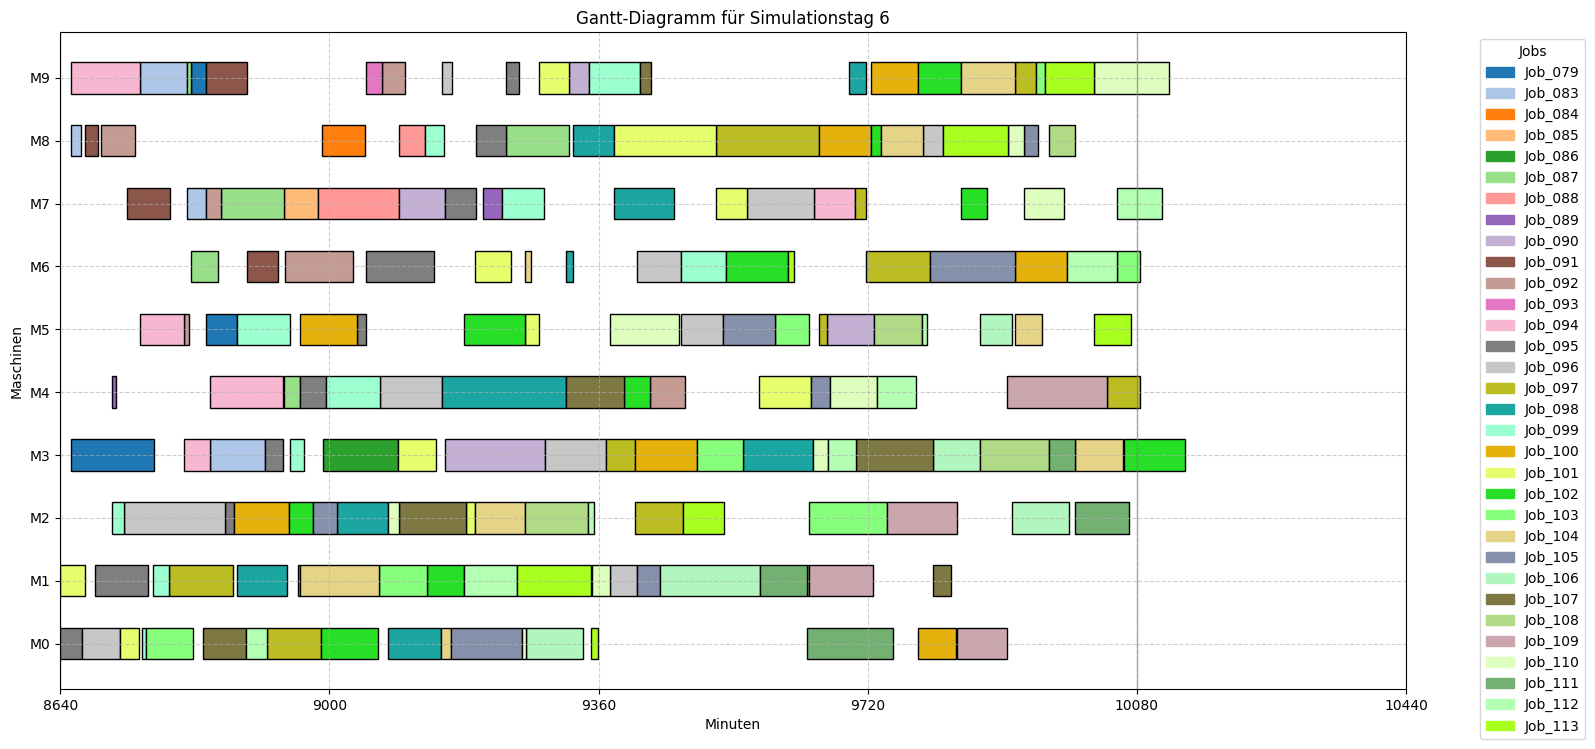

Number of undone operations: 14
_______________________________________________________________________________
Day 07: [10080, 11520)
	Current earliest Job_114:	Arrival: 8640	Deadline: 10655
	Undone earliest Job_100:	Arrival: 7512	Deadline: 9824
	Wating earliest Job_098:	Arrival: 7403	Deadline: 10181

Solver-Status         : OPTIMAL
Objective Value       : 154580.00
Best Objective Bound  : 154580.00
Laufzeit              : 22.12 Sekunden
Deviation terms       : 29


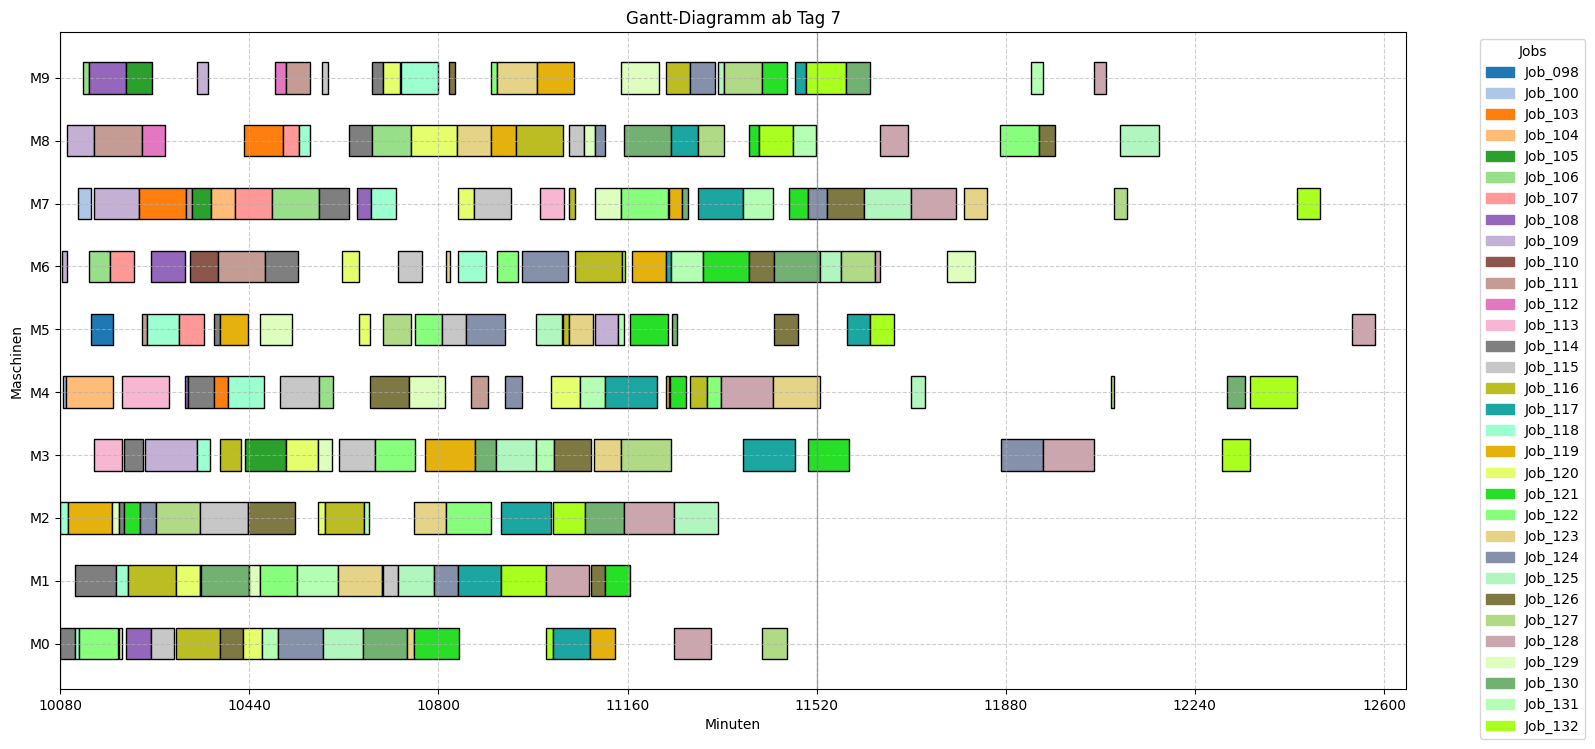

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job
label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         2
0              26
0 - 60          3
60 - 120        0
120 - 180       0
180 - 240       0
>240            1
Name: count, dtype: int64
Number of waiting operations: 27
[168:00:00] Job_114 started on M0
[168:00:00] Job_118 started on M2
[168:04:00] Job_109 started on M6
[168:05:00] Job_100 started on M4
[168:10:10] Job_100 finished on M4 (after 05 minutes 10 seconds)
[168:10:40] Job_109 finished on M6 (after 06 minutes 41 seconds)
[168:11:00] Job_104 started on M4
[168:13:00] Job_109 started on M8
[168:13:23] Job_118 finished on M2 (after 13 minutes 24 seconds)
[168:14:00] Job_119 started on M2
[168:31:55] Job_114 finished on M0 (after 31 minutes 56 seconds)
[168:31:55] Job_118 started on

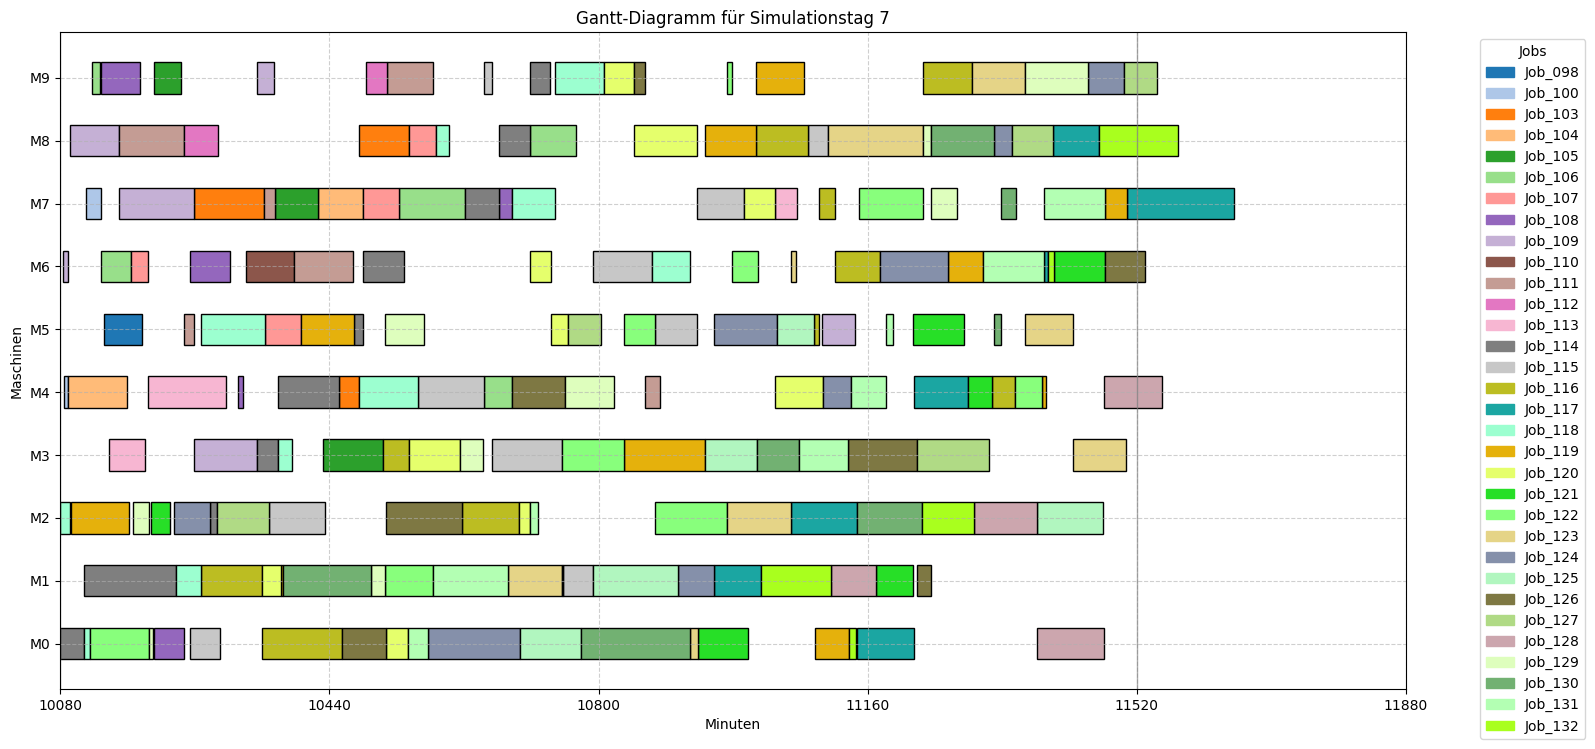

Number of undone operations: 14
_______________________________________________________________________________
Day 08: [11520, 12960)
	Current earliest Job_133:	Arrival: 10080	Deadline: 12095
	Undone earliest Job_117:	Arrival: 8843	Deadline: 11621
	Wating earliest Job_117:	Arrival: 8843	Deadline: 11621

Solver-Status         : OPTIMAL
Objective Value       : 187400.00
Best Objective Bound  : 187100.00
Laufzeit              : 52.66 Sekunden
Deviation terms       : 27


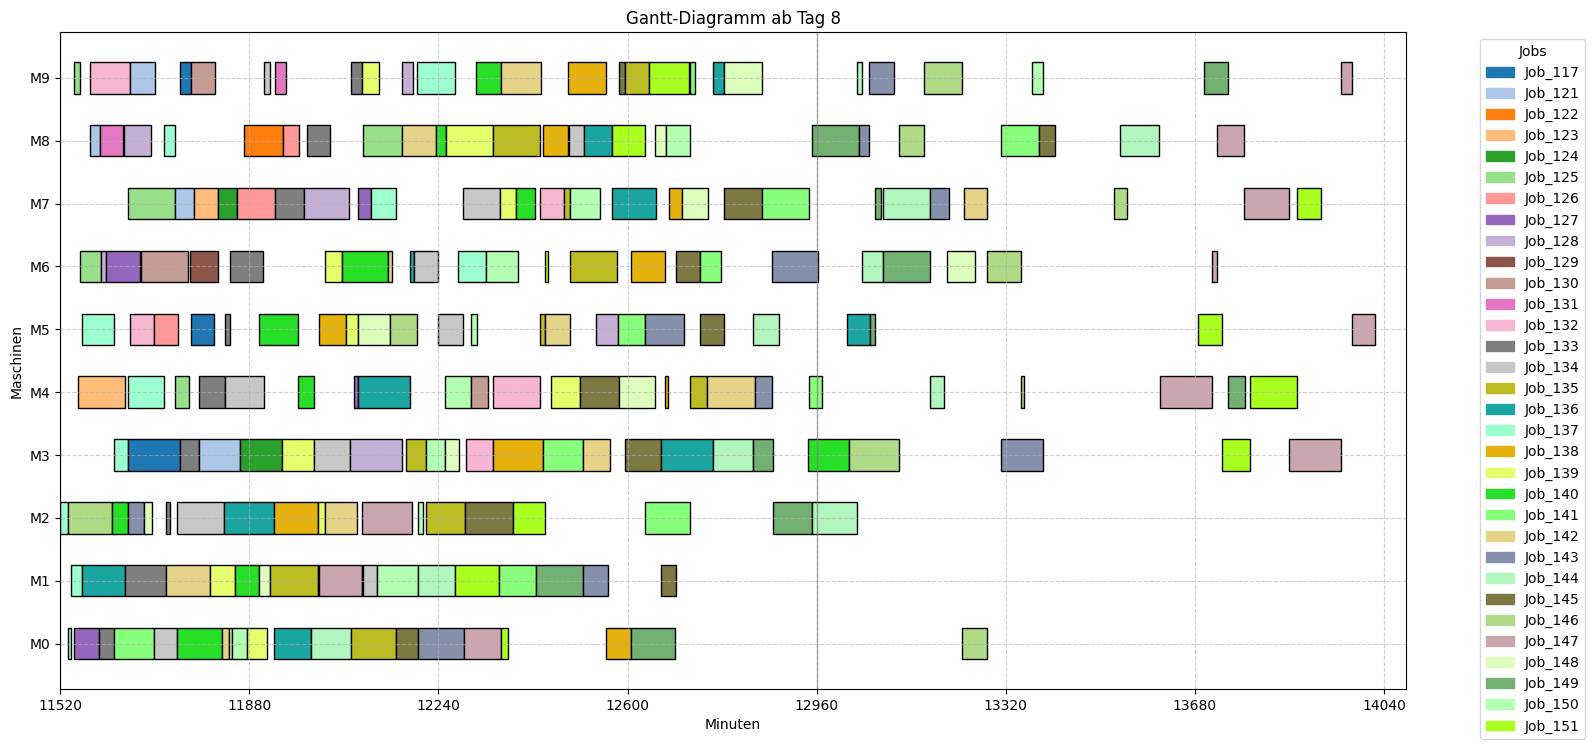

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job
label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         4
0              26
0 - 60          0
60 - 120        0
120 - 180       0
180 - 240       1
>240            1
Name: count, dtype: int64
Number of waiting operations: 38
[192:00:00] Job_137 started on M2
[192:10:51] Job_137 finished on M2 (after 10 minutes 51 seconds)
[192:14:00] Job_146 started on M2
[192:14:00] Job_137 started on M0
[192:19:49] Job_137 finished on M0 (after 05 minutes 50 seconds)
[192:20:00] Job_137 started on M1
[192:27:00] Job_125 started on M9
[192:27:00] Job_127 started on M0
[192:34:00] Job_123 started on M4
[192:34:19] Job_125 finished on M9 (after 07 minutes 20 seconds)
[192:38:00] Job_125 started on M6
[192:43:02] Job_137 finished on M1 (after 23 minutes 03 secon

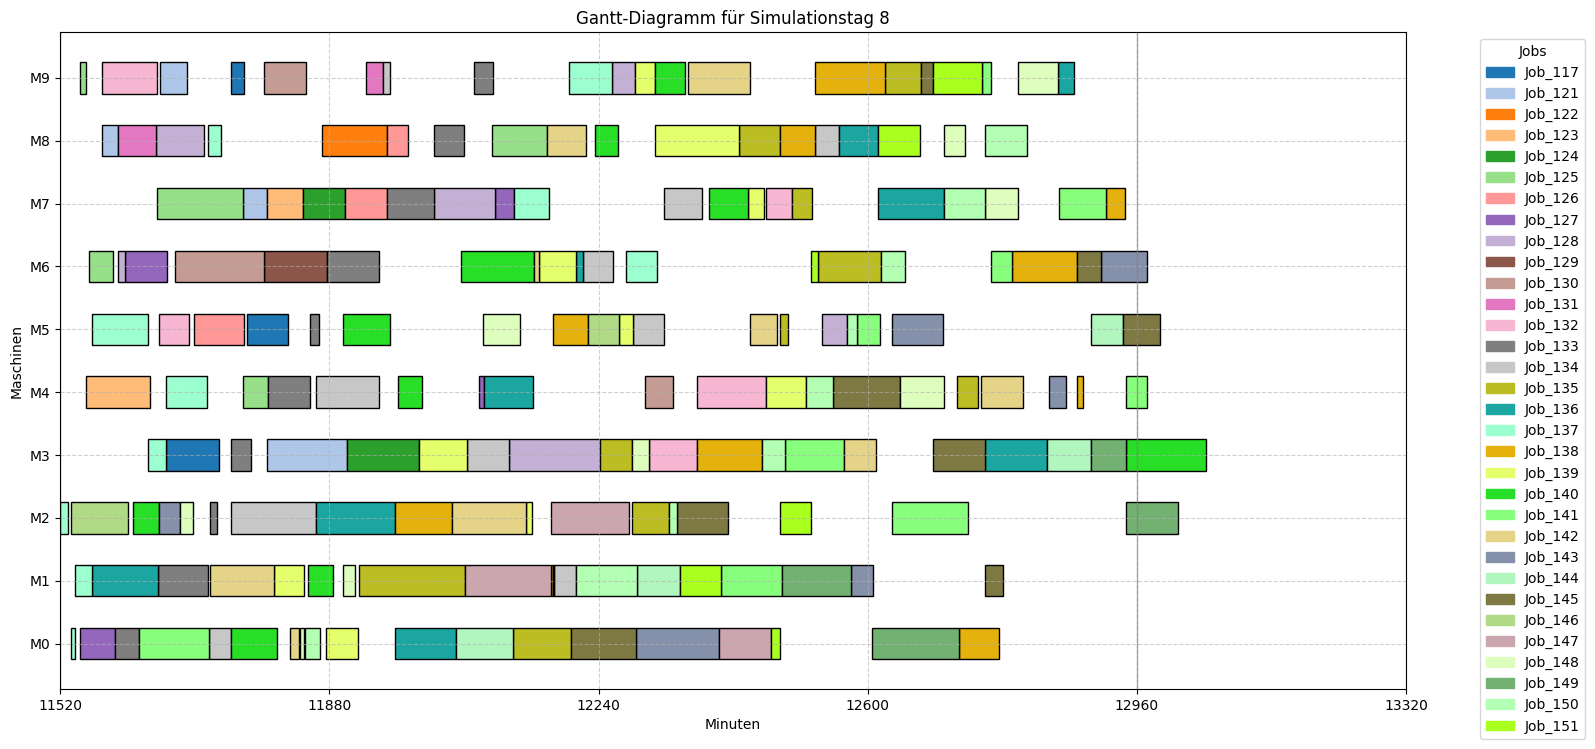

Number of undone operations: 3
_______________________________________________________________________________
Day 09: [12960, 14400)
	Current earliest Job_152:	Arrival: 11520	Deadline: 13535
	Undone earliest Job_144:	Arrival: 11004	Deadline: 13611
	Wating earliest Job_136:	Arrival: 10283	Deadline: 13061

Solver-Status         : OPTIMAL
Objective Value       : 61160.00
Best Objective Bound  : 61160.00
Laufzeit              : 7.61 Sekunden
Deviation terms       : 38


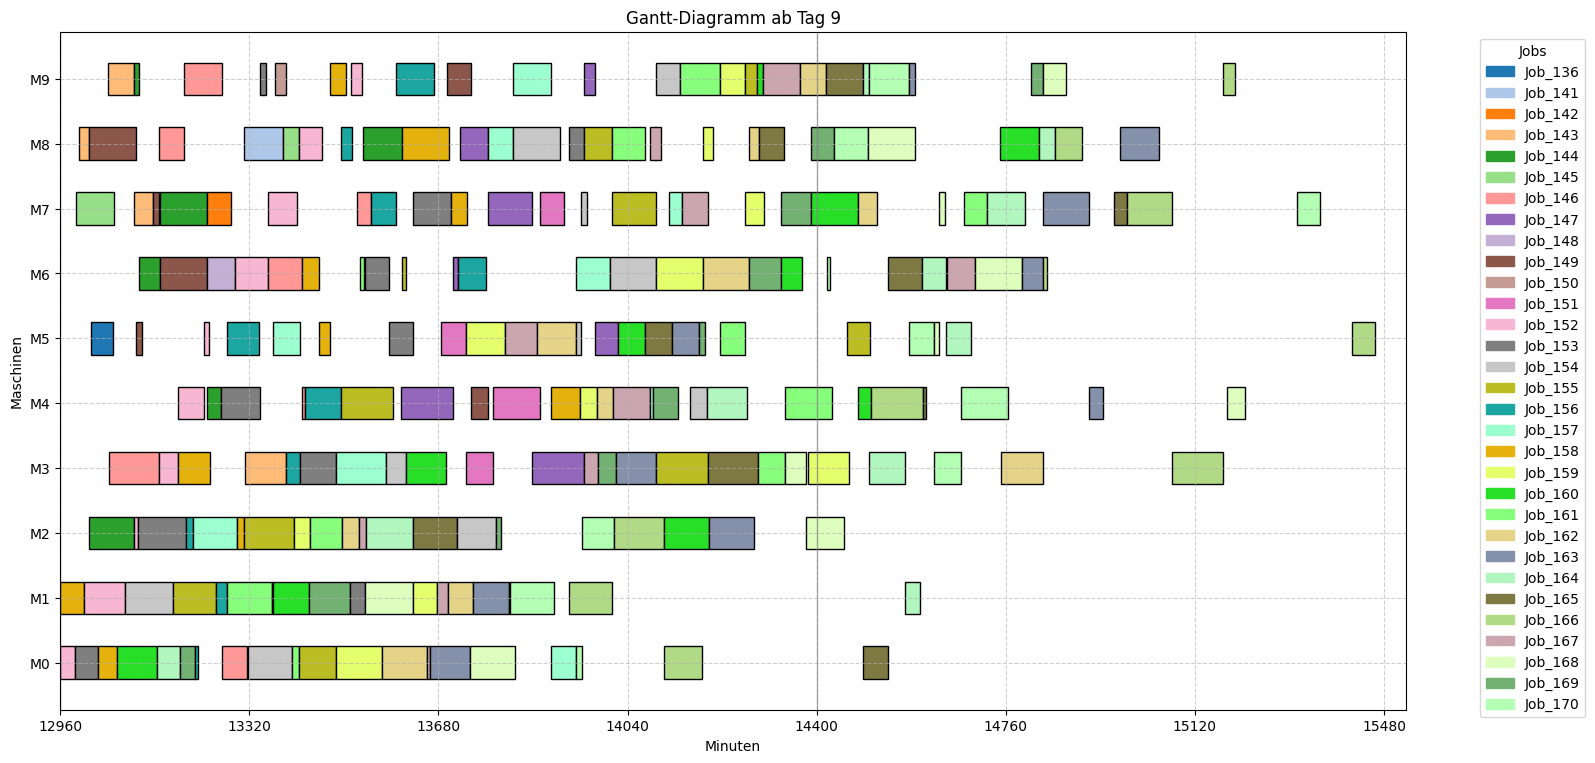

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job
label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         2
0              28
0 - 60          1
60 - 120        0
120 - 180       0
180 - 240       0
>240            0
Name: count, dtype: int64
Number of waiting operations: 45
[216:00:00] Job_152 started on M0
[216:00:00] Job_158 started on M1
[216:31:00] Job_145 started on M7
[216:36:00] Job_143 started on M8
[216:39:55] Job_152 finished on M0 (after 39 minutes 55 seconds)
[216:39:55] Job_153 started on M0
[216:55:00] Job_144 started on M2
[216:58:00] Job_136 started on M5
[216:58:41] Job_143 finished on M8 (after 22 minutes 41 seconds)
[216:58:41] Job_149 started on M8
[217:10:20] Job_158 finished on M1 (after 70 minutes 20 seconds)
[217:10:20] Job_152 started on M1
[217:31:47] Job_153 finishe

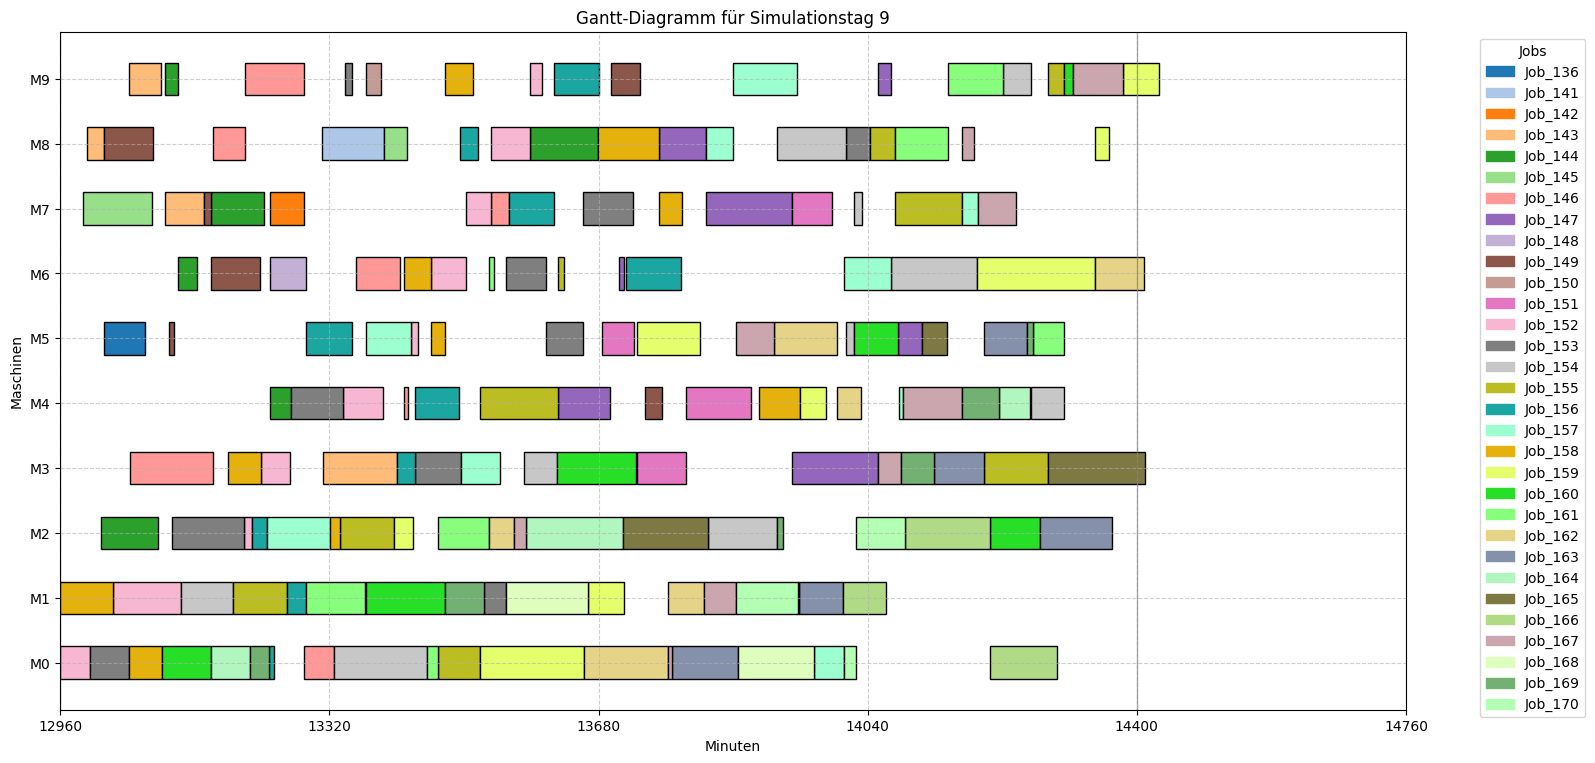

Number of undone operations: 14
_______________________________________________________________________________
Day 10: [14400, 15840)
	Current earliest Job_171:	Arrival: 12960	Deadline: 14975
	Undone earliest Job_159:	Arrival: 12024	Deadline: 14462
	Wating earliest Job_155:	Arrival: 11723	Deadline: 14501

Solver-Status         : FEASIBLE
Objective Value       : 149700.00
Best Objective Bound  : 121440.00
Laufzeit              : 10802.47 Sekunden
Deviation terms       : 45


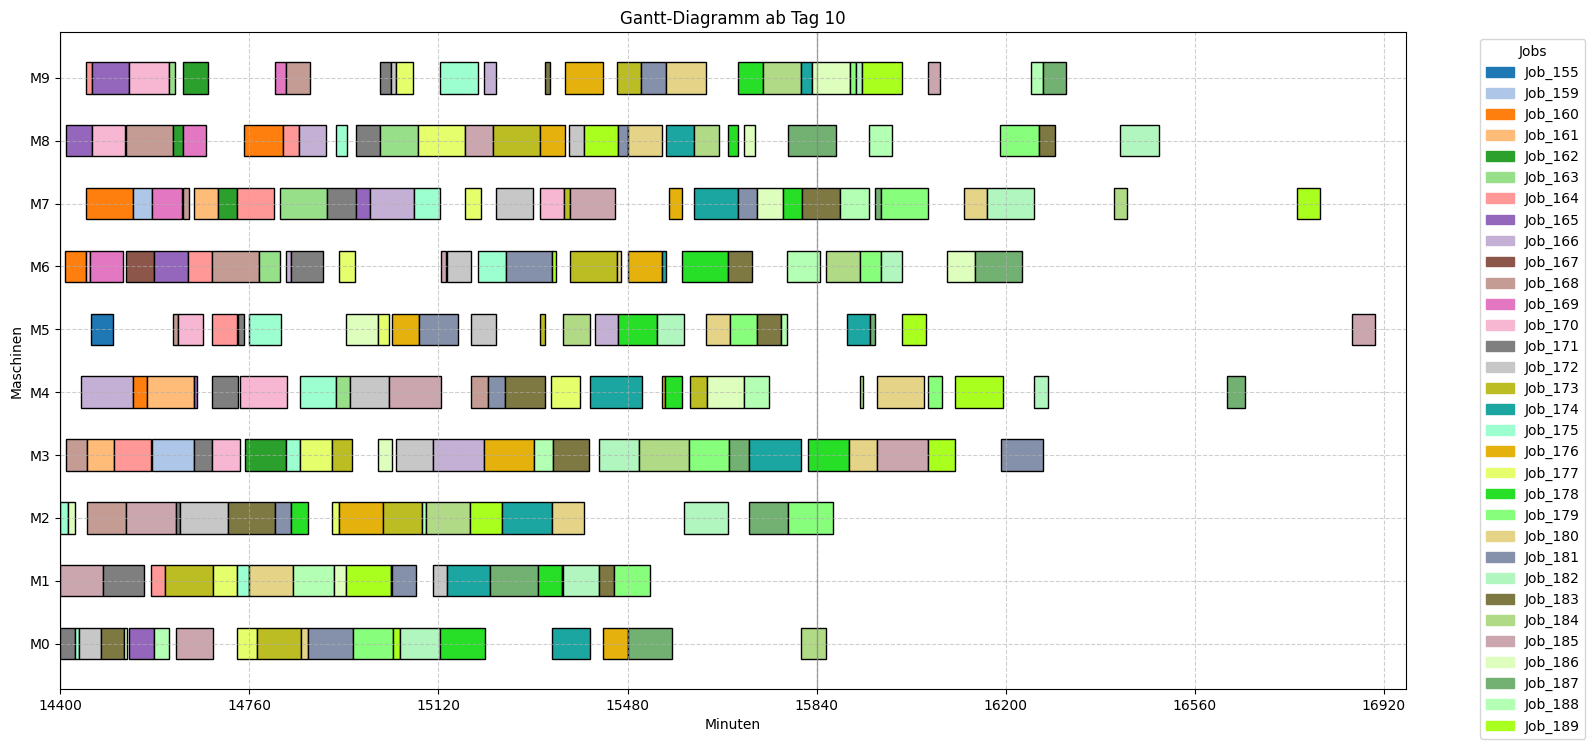

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job
label
<-240           0
-240 - -180     0
-180 - -120     1
-120 - -60      0
-60 - 0         4
0              23
0 - 60          3
60 - 120        0
120 - 180       0
180 - 240       1
>240            0
Name: count, dtype: int64
Number of waiting operations: 36
[240:00:00] Job_171 started on M0
[240:00:00] Job_175 started on M2
[240:00:00] Job_185 started on M1
[240:10:00] Job_160 started on M6
[240:12:00] Job_165 started on M8
[240:12:00] Job_168 started on M3
[240:13:56] Job_175 finished on M2 (after 13 minutes 56 seconds)
[240:14:00] Job_186 started on M2
[240:29:43] Job_171 finished on M0 (after 29 minutes 43 seconds)
[240:29:43] Job_175 started on M0
[240:33:52] Job_186 finished on M2 (after 19 minutes 52 seconds)
[240:34:54] Job_175 finished on M0 (after 05 minutes 11 secon

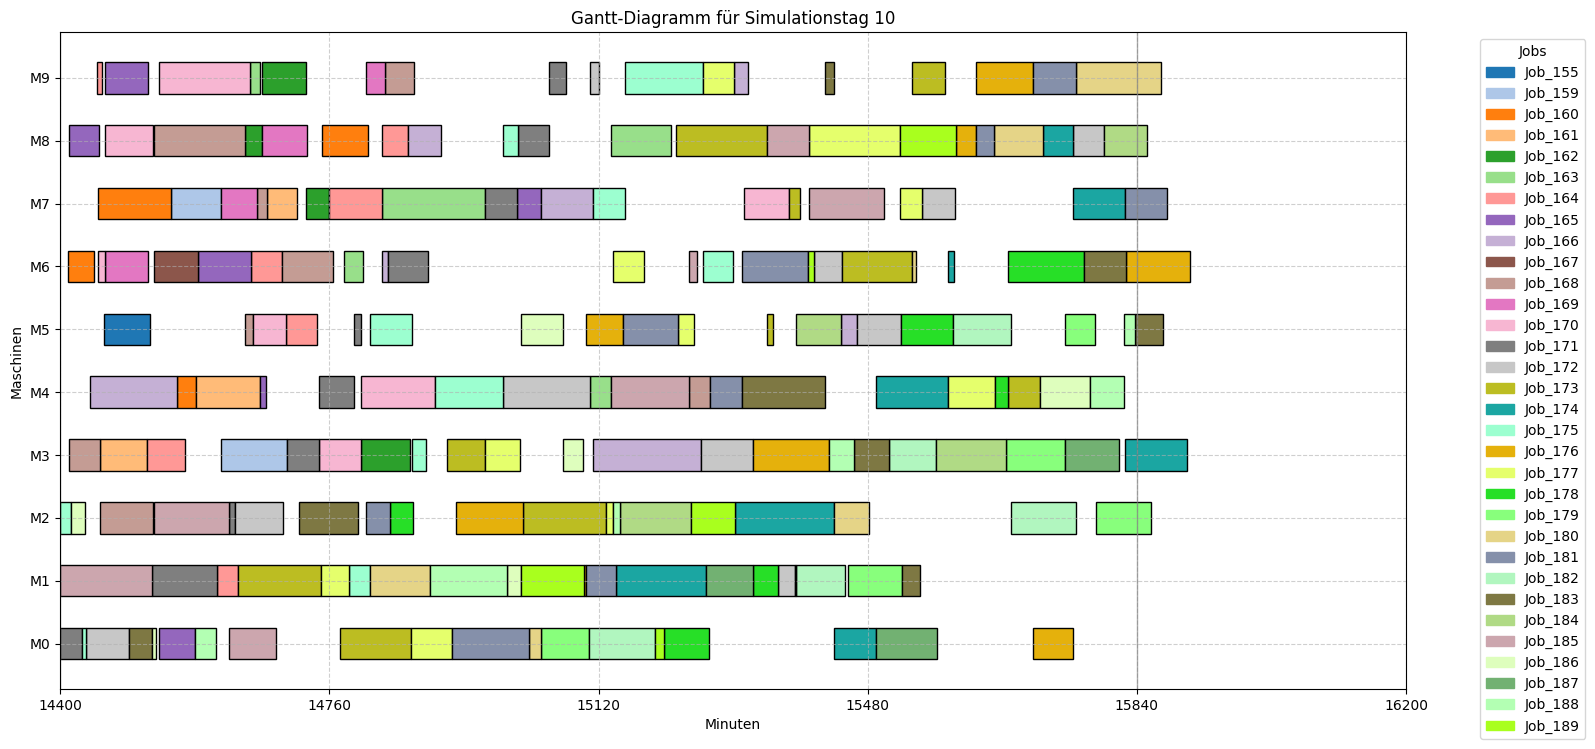

Number of undone operations: 17
_______________________________________________________________________________
Day 11: [15840, 17280)
	Current earliest Job_190:	Arrival: 14400	Deadline: 16415
	Undone earliest Job_174:	Arrival: 13163	Deadline: 15941
	Wating earliest Job_174:	Arrival: 13163	Deadline: 15941

Solver-Status         : FEASIBLE
Objective Value       : 308960.00
Best Objective Bound  : 289280.00
Laufzeit              : 10802.21 Sekunden
Deviation terms       : 36


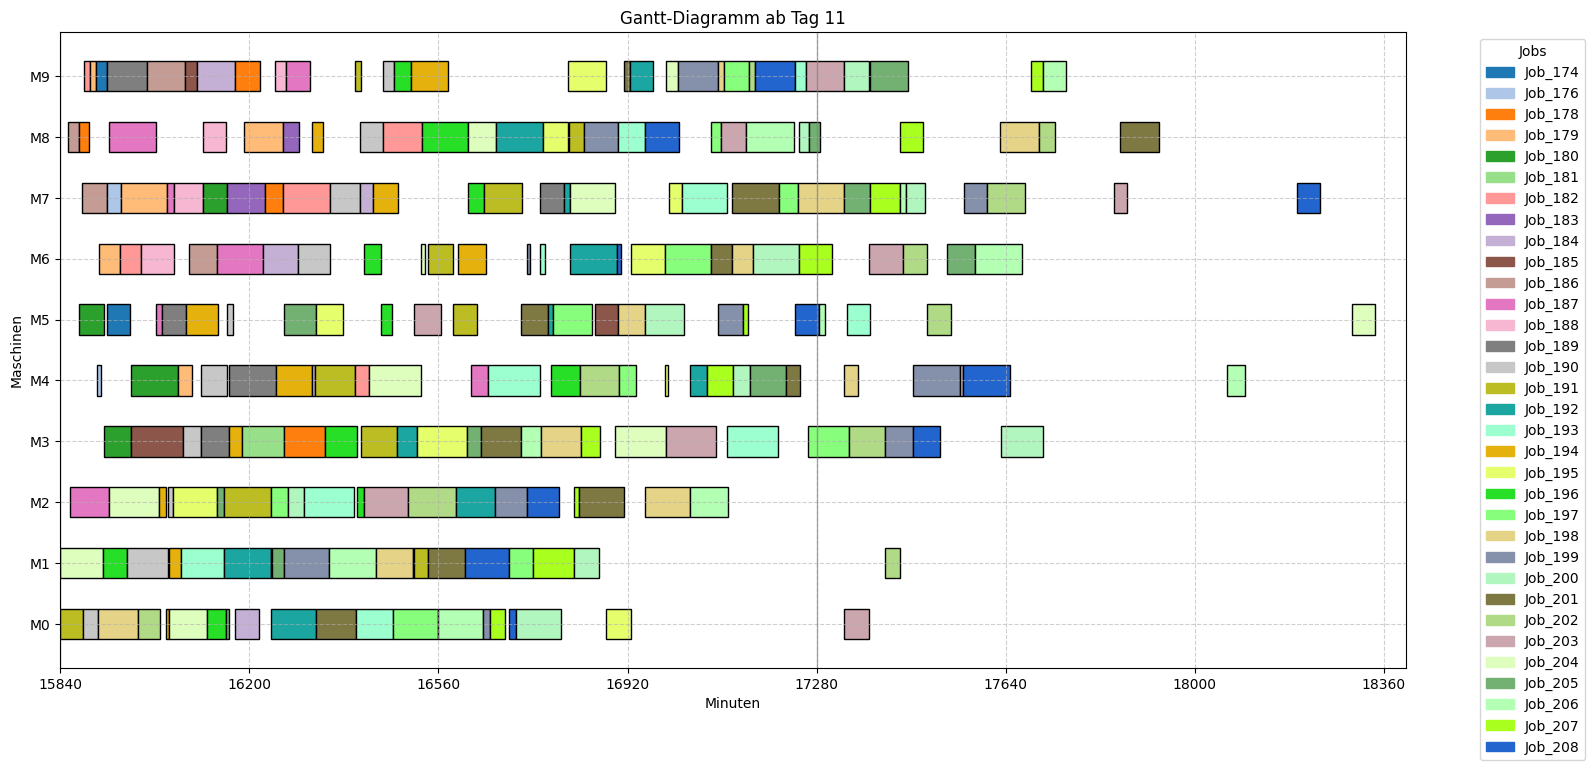

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job
label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         5
0              22
0 - 60          3
60 - 120        1
120 - 180       0
180 - 240       0
>240            2
Name: count, dtype: int64
Number of waiting operations: 35
[264:00:00] Job_191 started on M0
[264:00:00] Job_204 started on M1
[264:14:00] Job_186 started on M8
[264:19:00] Job_187 started on M2
[264:33:43] Job_191 finished on M0 (after 33 minutes 44 seconds)
[264:35:25] Job_186 finished on M8 (after 21 minutes 26 seconds)
[264:35:25] Job_178 started on M8
[264:36:00] Job_180 started on M5
[264:41:00] Job_186 started on M7
[264:43:00] Job_190 started on M0
[264:46:00] Job_182 started on M9
[264:49:12] Job_178 finished on M8 (after 13 minutes 47 seconds)
[264:55:36] Job_182 finishe

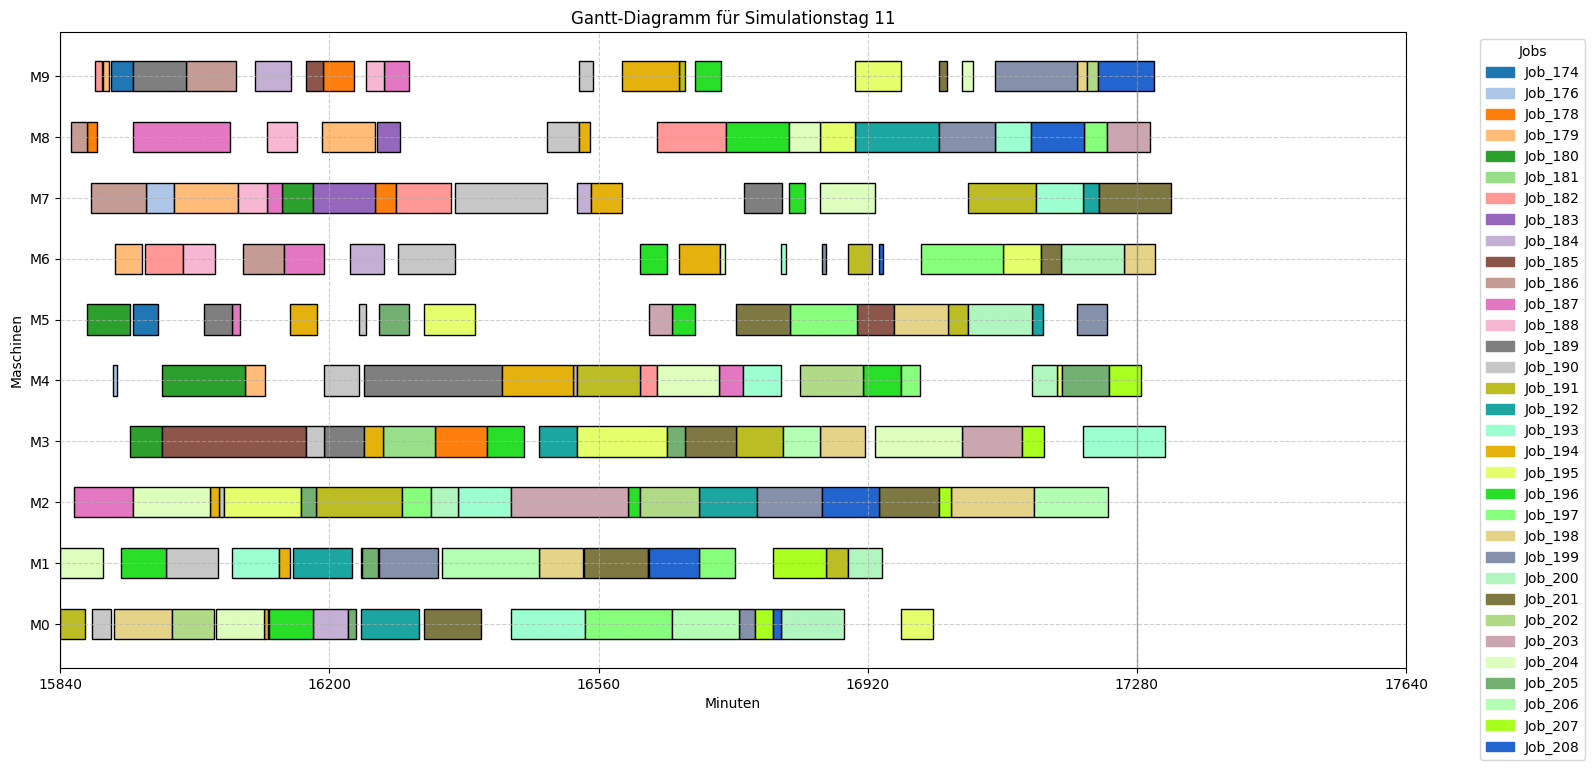

Number of undone operations: 18
_______________________________________________________________________________
Day 12: [17280, 18720)
	Current earliest Job_209:	Arrival: 15840	Deadline: 17855
	Undone earliest Job_191:	Arrival: 14486	Deadline: 16838
	Wating earliest Job_193:	Arrival: 14603	Deadline: 17381

Solver-Status         : FEASIBLE
Objective Value       : 460000.00
Best Objective Bound  : 419520.00
Laufzeit              : 10812.85 Sekunden
Deviation terms       : 35


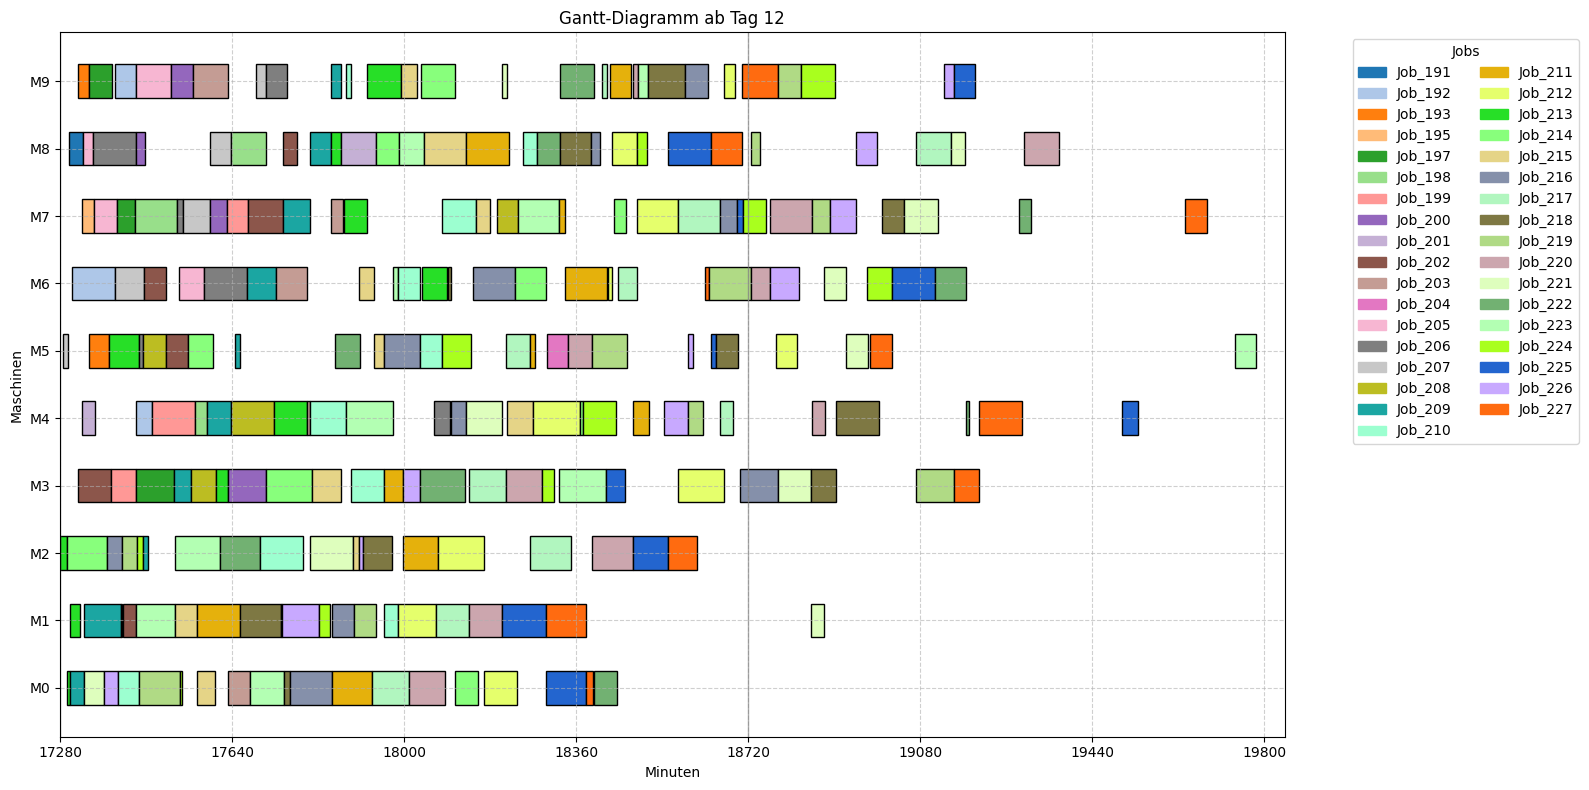

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job
label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         2
0              23
0 - 60          5
60 - 120        1
120 - 180       1
180 - 240       0
>240            3
Name: count, dtype: int64
Number of waiting operations: 36
[288:00:00] Job_213 started on M2
[288:06:00] Job_207 started on M5
[288:14:14] Job_213 finished on M2 (after 14 minutes 14 seconds)
[288:14:14] Job_214 started on M2
[288:14:14] Job_213 started on M0
[288:17:54] Job_207 finished on M5 (after 11 minutes 55 seconds)
[288:18:00] Job_191 started on M8
[288:19:24] Job_213 finished on M0 (after 05 minutes 10 seconds)
[288:20:00] Job_209 started on M0
[288:20:00] Job_213 started on M1
[288:25:00] Job_192 started on M6
[288:35:40] Job_191 finished on M8 (after 17 minutes 40 secon

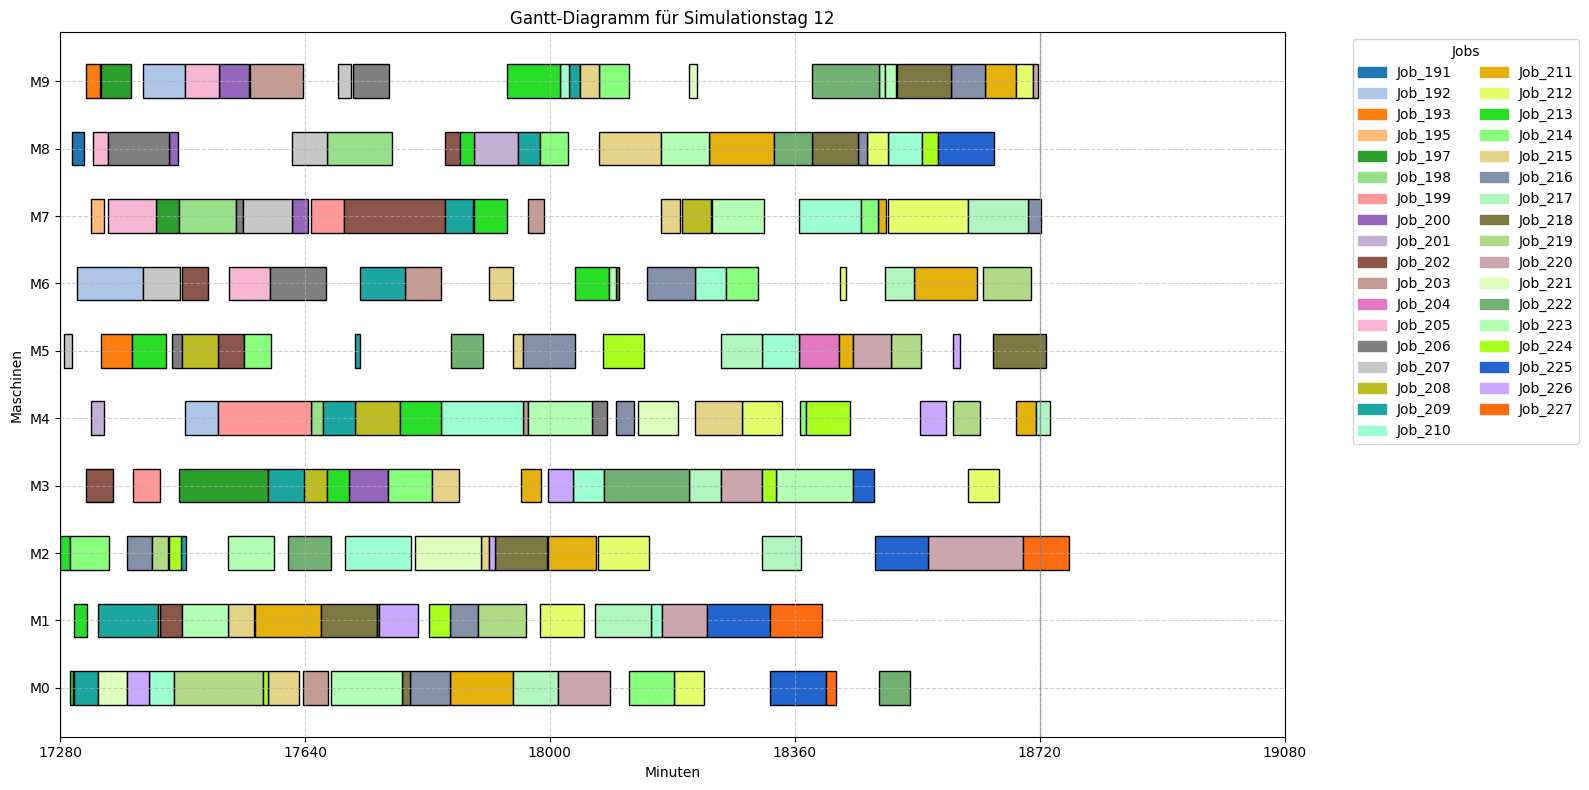

Number of undone operations: 7
_______________________________________________________________________________


In [14]:
for day_numb in range(first_start, last_planning_start + 1):
    day_start = day_length*day_numb 
    day_end = day_start + day_length
    print(f"Day {day_numb:02d}: [{day_start}, {day_end})")

    # ------------------------ I. Operationsvorbereitung ------------------------
    
    # ---------- a) Filterung nach der aktuellen "Ready Time" ----------
    df_jobs_curr, df_ops_curr = rp_proced.filter_ops_and_jobs_by_ready_time(df_jobs_all, df_ops_all, ready_time = day_start)
    print_earliest_job(df_jobs_curr, "Current")

    # ---------- b) Unerledigte Operationen ----------------------------

    df_ops_undone = df_ops_all.merge(df_plan_undone[["Job", "Operation"]], on=["Job", "Operation"], how="inner")
    df_jobs_undone = df_jobs_all[df_jobs_all["Job"].isin(df_ops_undone["Job"].unique())]
    print_earliest_job(df_jobs_undone, "Undone")
    
    # ---------- c) Wartende Operationen -------------------------------

    df_ops_waiting = df_ops_all.merge(df_plan_waiting[["Job", "Operation"]], on=["Job", "Operation"], how="inner")
    df_jobs_waiting = df_jobs_all[df_jobs_all["Job"].isin(df_plan_waiting["Job"].unique())]
    print_earliest_job(df_jobs_waiting, "Wating")

    # ---------- Zusammenführung ---------------------------------------

    df_ops_curr_combined = pd.concat([df_ops_curr, df_ops_waiting, df_ops_undone], ignore_index=True)
    df_jobs_curr_combined  = pd.concat([df_jobs_curr, df_jobs_waiting, df_jobs_undone], ignore_index=True)
    df_jobs_curr_combined = df_jobs_curr_combined.drop_duplicates(subset="Job", keep="first").sort_values(by="Job").reset_index(drop=True)

    # ------------------------ Ib. Vorherige Plan ------------------------------- 

    # V1 
    df_plan_prev = df_plan_waiting

    # V2
     # df_plan_prev = pd.concat([df_plan_waiting, df_plan_undone]).sort_values(by=["Job", "Start"]).reset_index(drop=True)
    
    # ------------------------ II. Rescheduling ---------------------------------

    # Reduktion der bereits ausgeführten Operationen, die im heutigen Plan hineinlaufen
    df_execution_important = df_execution[df_execution["End"] >= day_start]

    # Rescheduling
    df_plan = rssv.solve_cp_jssp_lateness_by_tardiness_and_earliness_with_devpen(df_ops_curr_combined, df_jobs_curr_combined , 
                                                                                 df_execution_important,
                                                                                 df_original_plan = df_plan_prev,
                                                                                 w_t = 5,
                                                                                 r = 0.40, # 40% Lateness, 60% Deviation
                                                                                 reschedule_start = day_start, msg=False, 
                                                                                 timeLimit=max_time, gapRel= 0.002)
    df_plan.to_csv(file_template.format(text= f"schedule_{day_numb:02d}"), index=False)

    show.plot_gantt_machines(df_plan, title=f"Gantt-Diagramm ab Tag {day_numb}")
    check.is_machine_conflict_free(df_plan)
    check.is_operation_sequence_correct(df_plan)
    check.is_job_timing_correct(df_plan)
    check.is_start_correct(df_plan)
    
    last_ops = df_plan.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
    print(show.count_column_grouped(last_ops, "Lateness", max_val = 240, steps= 60))

    
    # ------------------------ III. Aufteilung des Schedules --------------------

    df_plan_for_sim = rp_proced.filter_plan_for_today(df_plan, latest_op_start = day_end)
    
    df_plan_waiting = rp_proced.filter_plan_for_future(df_plan, earliest_op_start = day_end)
    waiting_numb = len(df_plan_waiting)
    print(f"Number of waiting operations: {waiting_numb}")


    # ------------------------ IV. Simulation -----------------------------------

    simulation = ProductionDaySimulation(df_plan_for_sim, vc=0.25)
    df_execution, df_plan_undone = simulation.run(start_time = day_start, end_time=day_end)

    if not df_execution.empty:
        show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm für Simulationstag {day_numb}", duration_column="Simulated Processing Time")
    else:
        print(f"Nothing executed on day {day_numb}")

    undone_numb = len(df_plan_undone)
    print(f"Number of undone operations: {undone_numb}")
    print("_"*79)